<a href="https://colab.research.google.com/github/rasmibhattarai72/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio('/content/drive/MyDrive/AI Hackathon Dataset/brainn-tumor', output='output', seed=1337, ratio=(.8,.1, .1), group_prefix=None)

Copying files: 7023 files [01:27, 80.21 files/s] 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pickle
import cv2
import PIL
import pathlib
import tensorflow as tf
import easydict

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.applications import MobileNetV2

In [ ]:
def plot_curves(acc, val_acc, loss, val_loss):
  plt.figure(figsize=(8, 8))
  
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend(); 

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.legend()
  plt.show();

In [ ]:
args = easydict.EasyDict({
        "test": "/content/output/test",
        "train":"/content/output/train",
        "val" :"/content/output/val",
})

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (240, 240)

In [ ]:
train_dataset = image_dataset_from_directory(args['train'],
                                             shuffle=True,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(args['test'], image_size=IMG_SIZE,
                                            label_mode='categorical'
                                            )
val_dataset = image_dataset_from_directory(args['val'],
                                           label_mode = 'categorical',
                                           batch_size=BATCH_SIZE,
                                           image_size=IMG_SIZE)
class_names = test_dataset.class_names

Found 5617 files belonging to 4 classes.
Found 705 files belonging to 4 classes.
Found 701 files belonging to 4 classes.


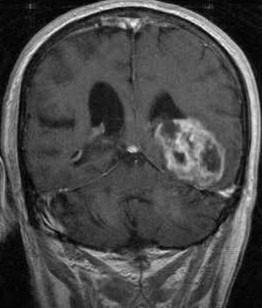

In [ ]:
img_1 = os.path.join('/content/drive/MyDrive/AI Hackathon Dataset/brainn-tumor/meningioma/Te-meTr_0007.jpg')
PIL.Image.open(str(img_1))

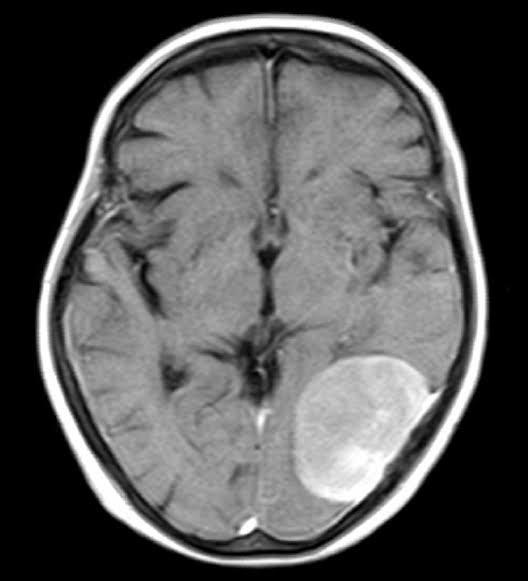

In [ ]:
img_2 = os.path.join('/content/drive/MyDrive/AI Hackathon Dataset/brainn-tumor/meningioma/Te-meTr_0004.jpg')

PIL.Image.open(str(img_2))

In [ ]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([RandomFlip('horizontal'),
                                         RandomRotation(0.2),
                                      ])

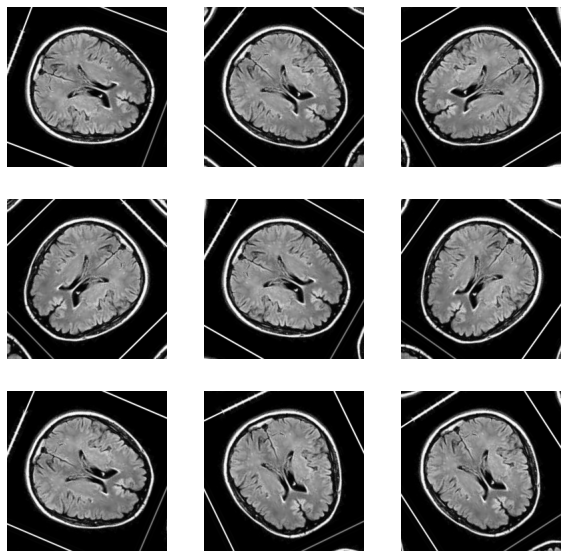

In [ ]:
#Let's see the augmented images
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Creating base model from pre-trained model MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
#Architecture of base model
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 120, 120, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 120, 120, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')
prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)

(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=(240, 240, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_avg_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=Adam(lr=base_learning_rate),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Let's see the summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 240, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 240, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
#Fitting the model
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset)

Epoch 1/15
176/176 [==============================] - 27s 108ms/step - loss: 1.2123 - accuracy: 0.4764 - val_loss: 0.9298 - val_accuracy: 0.6662
Epoch 2/15
176/176 [==============================] - 18s 98ms/step - loss: 0.7760 - accuracy: 0.7365 - val_loss: 0.7059 - val_accuracy: 0.7646
Epoch 3/15
176/176 [==============================] - 17s 93ms/step - loss: 0.6271 - accuracy: 0.7885 - val_loss: 0.6007 - val_accuracy: 0.8046
Epoch 4/15
176/176 [==============================] - 19s 107ms/step - loss: 0.5518 - accuracy: 0.8134 - val_loss: 0.5399 - val_accuracy: 0.8174
Epoch 5/15
176/176 [==============================] - 19s 106ms/step - loss: 0.5066 - accuracy: 0.8268 - val_loss: 0.4975 - val_accuracy: 0.8317
Epoch 6/15
176/176 [==============================] - 16s 92ms/step - loss: 0.4676 - accuracy: 0.8437 - val_loss: 0.4657 - val_accuracy: 0.8345
Epoch 7/15
176/176 [==============================] - 18s 103ms/step - loss: 0.4447 - accuracy: 0.8469 - val_loss: 0.4427 - val_accur

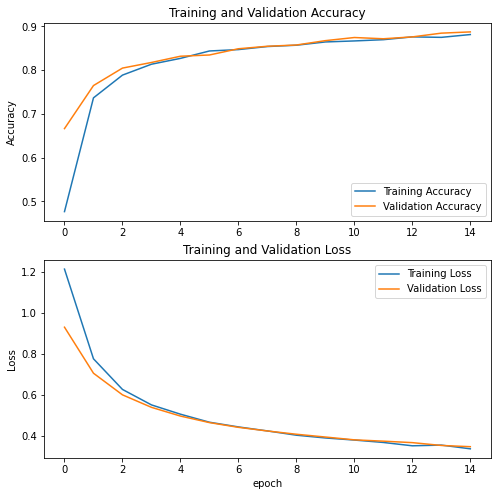

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#Let's plot the curves
plot_curves(acc, val_acc, loss, val_loss)

In [ ]:
base_model.trainable = True

In [ ]:
# Freezing all layers before the 100th layer
for layer in base_model.layers[:100]:
  layer.trainable =  False

In [ ]:
#Compiling the model
model.compile(loss = CategoricalCrossentropy(),
              optimizer = RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
len(model.trainable_variables)

56

In [ ]:
#Fitting the model
history_fine = model.fit(train_dataset,
                         epochs=15,
                          validation_data=val_dataset)

Epoch 1/15
176/176 [==============================] - 28s 124ms/step - loss: 0.3082 - accuracy: 0.8857 - val_loss: 0.2534 - val_accuracy: 0.9101
Epoch 2/15
176/176 [==============================] - 21s 119ms/step - loss: 0.2507 - accuracy: 0.9087 - val_loss: 0.2135 - val_accuracy: 0.9244
Epoch 3/15
176/176 [==============================] - 21s 119ms/step - loss: 0.2178 - accuracy: 0.9195 - val_loss: 0.2633 - val_accuracy: 0.9058
Epoch 4/15
176/176 [==============================] - 21s 118ms/step - loss: 0.1871 - accuracy: 0.9293 - val_loss: 0.2293 - val_accuracy: 0.9201
Epoch 5/15
176/176 [==============================] - 22s 124ms/step - loss: 0.1602 - accuracy: 0.9423 - val_loss: 0.1643 - val_accuracy: 0.9529
Epoch 6/15
176/176 [==============================] - 21s 118ms/step - loss: 0.1441 - accuracy: 0.9468 - val_loss: 0.1522 - val_accuracy: 0.9458
Epoch 7/15
176/176 [==============================] - 23s 128ms/step - loss: 0.1236 - accuracy: 0.9567 - val_loss: 0.1590 - val_ac

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

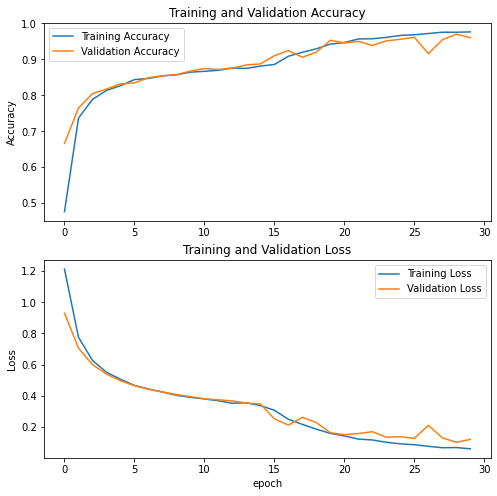

In [ ]:
plot_curves(acc, val_acc, loss, val_loss)

In [ ]:
#Evaluation on test set
model.evaluate(test_dataset)

23/23 [==============================] - 2s 63ms/step - loss: 0.1046 - accuracy: 0.9560


[0.10464664548635483, 0.9560283422470093]

In [ ]:
#Saving the model
model.save('Brain-tumor.h5')

In [ ]:
#Loading the saved model
model1 = tf.keras.models.load_model('Brain-tumor.h5')

In [ ]:
#Let's see on a batch of test images
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model1.predict_on_batch(image_batch).flatten()

# Applying softmax 
predictions = tf.nn.softmax(predictions)
predictions = tf.where(predictions < 0.3, 0, 1)

In [ ]:
from keras.preprocessing import image

img_width, img_height = 240, 240

# Getting test image
test_image = tf.keras.utils.load_img('/content/drive/MyDrive/AI Hackathon Dataset/brainn-tumor/meningioma/Te-meTr_0003.jpg', target_size=(img_width, img_height))
test_image = tf.keras.utils.img_to_array(test_image)
#print(type(test_image))
#print(test_image.shape)
test_image = np.expand_dims(test_image, axis=0)

test_image = test_image.reshape(240, 240, 3) 
test_image = np.expand_dims(test_image, axis=0)   

result = model1.predict(test_image, batch_size=1)
print ((result))

1/1 [==============================] - 1s 636ms/step
[[0.00230089 0.7410296  0.01963593 0.2370335 ]]


In [ ]:
#Let's create a function to test the given image

def test_on_image(img_path):
  test_image = tf.keras.utils.load_img(img_path, target_size=(240,240))
  test_image = tf.keras.utils.img_to_array(test_image)
  #print(type(test_image))
  #print(test_image.shape)
  test_image = test_image.reshape(240, 240, 3)
  test_image = np.expand_dims(test_image, axis=0) 
  result = model1.predict(test_image)
  #print(type(result))
  p = max(result.tolist())
  return(class_names[p.index(max(p))])

In [ ]:
img_5 = "/content/drive/MyDrive/AI Hackathon Dataset/brainn-tumor/meningioma/Te-meTr_0006.jpg"

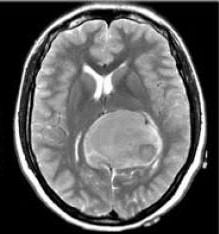

In [ ]:
PIL.Image.open(str(img_5))

In [ ]:
test_on_image(img_5)

1/1 [==============================] - 1s 626ms/step


'meningioma'

In [ ]:
test_on_image('/content/drive/MyDrive/AI Hackathon Dataset/brainn-tumor/glioma/Te-glTr_0002.jpg')

1/1 [==============================] - 0s 26ms/step


'glioma'